### Run basic `scanpy` QC and doublet detection with `scrublet` for merged, post-`cellbender` `23-0092` dataset

- **Developed by**: Carlos Talavera-López PhD
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230830

### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
asttokens           NA
backcall            0.2.0
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
executing           1.2.0
h5py                3.9.0
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.40.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numpy               1.24.4
packaging           23.1
pandas              2.0.3
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.10.0
prompt_toolkit      3.0.39
psutil              5.9.5
ptyprocess          0.7.0
pure_eval           0.2.2
pydev_ipython       NA
pydevconsole        

In [3]:
path = '../data/'

### Read individual `anndata` objects and predict doublets per sample

In [4]:
adata = sc.read_h5ad(path + 'heart_mm_nuclei-23-0092_CB_ctl230830.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 188253 × 32285
    obs: 'sample', 'genotype', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
sc.pp.filter_cells(adata, min_genes = 200)
print(adata.n_obs, adata.n_vars)

filtered out 40733 cells that have less than 200 genes expressed
147520 32285


In [10]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    scrub = scr.Scrublet(sample_adata.X, expected_doublet_rate = 0.1)

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()

    adata.obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    #scrub.plot_histogram()

    #plt.show()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 10.2%
Estimated detectable doublet fraction = 54.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 18.6%
Elapsed time: 2.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Elapsed time: 71.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 12.5%
Estimated detectable doublet fraction = 68.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 18.2%
Elapsed time: 8.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 11.4%
Estimated detectable double

In [11]:
adata

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'genome'

In [12]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'genome'

In [13]:
sample_object.shape

(147520, 32285)

### Compute QC stats

In [14]:
sample_object.shape

(147520, 32285)

In [15]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('mt-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("Rps","Rpl"))
sample_object.var

,gene_ids,feature_types,genome,mt,ribo
Xkr4,ENSMUSG00000051951,Gene Expression,NA,False,False
Gm1992,ENSMUSG00000089699,Gene Expression,NA,False,False
Gm19938,ENSMUSG00000102331,Gene Expression,NA,False,False
Gm37381,ENSMUSG00000102343,Gene Expression,NA,False,False
Rp1,ENSMUSG00000025900,Gene Expression,NA,False,False
...,...,...,...,...,...
AC124606.1,ENSMUSG00000095523,Gene Expression,NA,False,False
AC133095.2,ENSMUSG00000095475,Gene Expression,NA,False,False
AC133095.1,ENSMUSG00000094855,Gene Expression,NA,False,False
AC234645.1,ENSMUSG00000095019,Gene Expression,NA,False,False


In [16]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [17]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('mt-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)

In [18]:
sample_object

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC covariates

In [19]:
sample_object.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

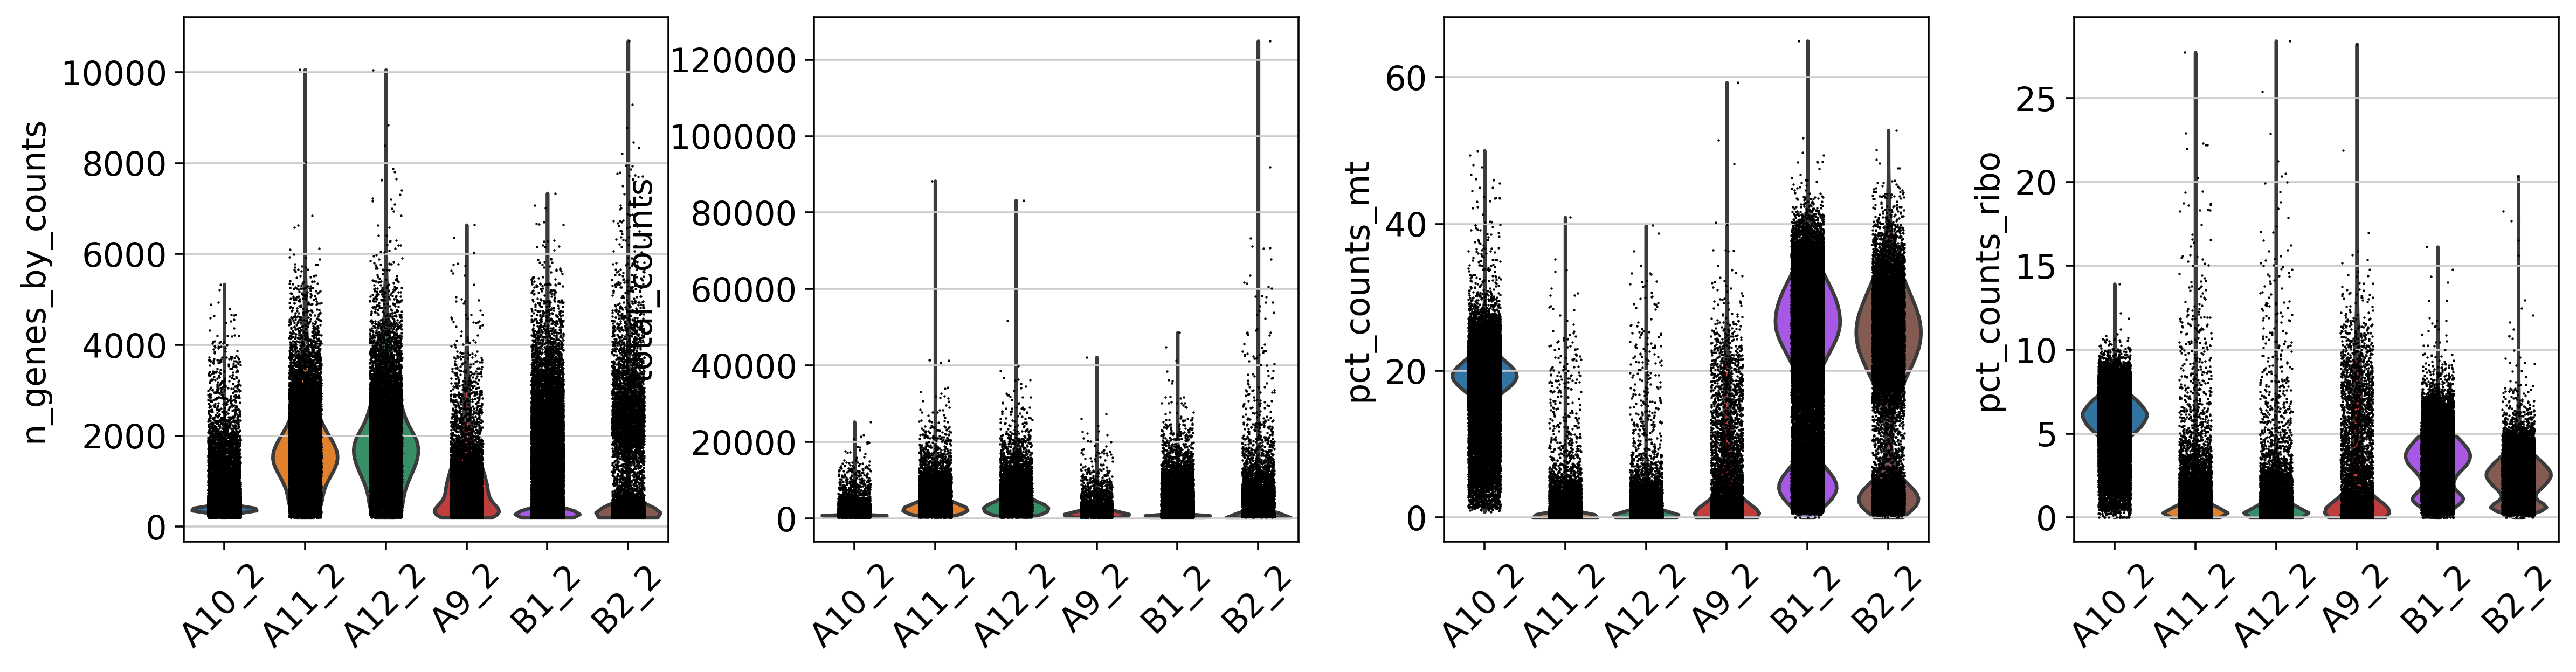

In [20]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

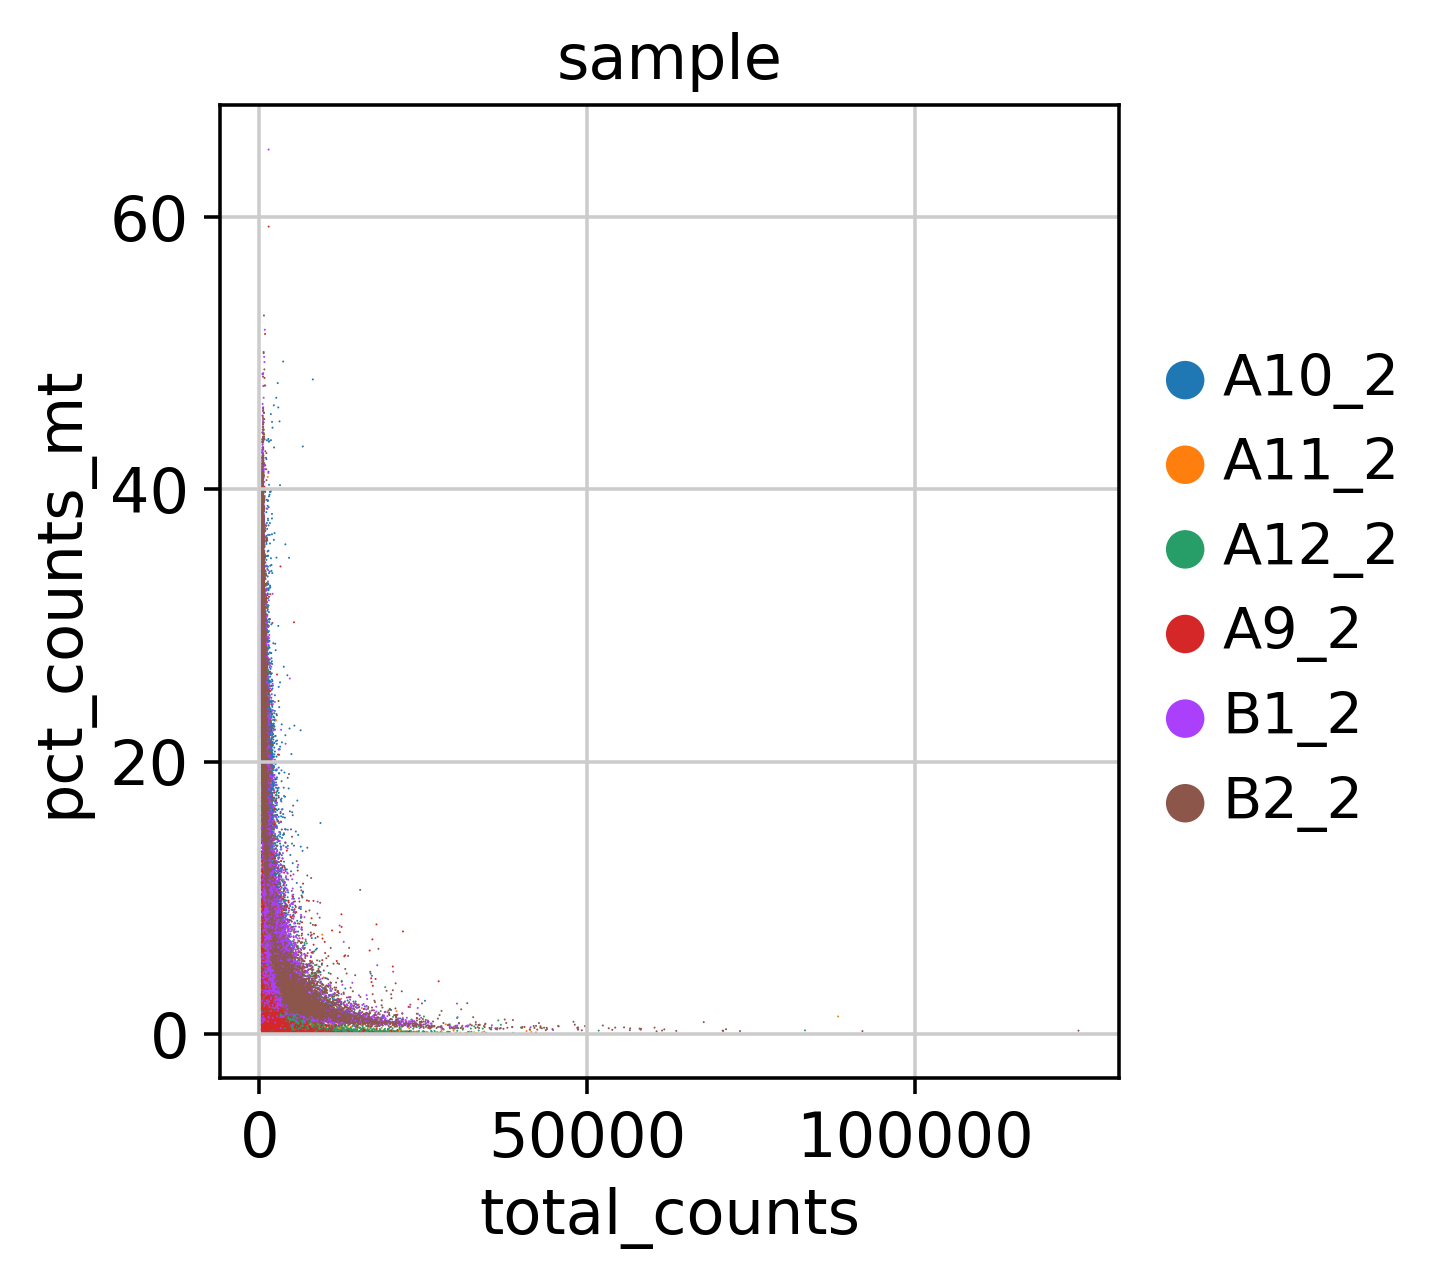

In [21]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "sample")

### Add sample sex covariate

In [22]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [23]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
mt-Tf,ENSMUSG00000064336,1,68,MT
mt-Rnr1,ENSMUSG00000064337,70,1024,MT
mt-Tv,ENSMUSG00000064338,1025,1093,MT
mt-Rnr2,ENSMUSG00000064339,1094,2675,MT
mt-Tl1,ENSMUSG00000064340,2676,2750,MT


In [24]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Gm29089', 'Zfy1', 'Uba1y', 'Gm28588', 'Gm28587', 'Kdm5d', 'Eif2s3y',
       'Gm29650', 'Uty', 'Ddx3y',
       ...
       'Gm28673', 'Gm28674', 'Gm21996', 'Gm28930', 'Gm29504', 'Gm20837',
       'Gm28300', 'Gm28301', 'Gm21860', 'Gm47283'],
      dtype='object', length=721)

In [25]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

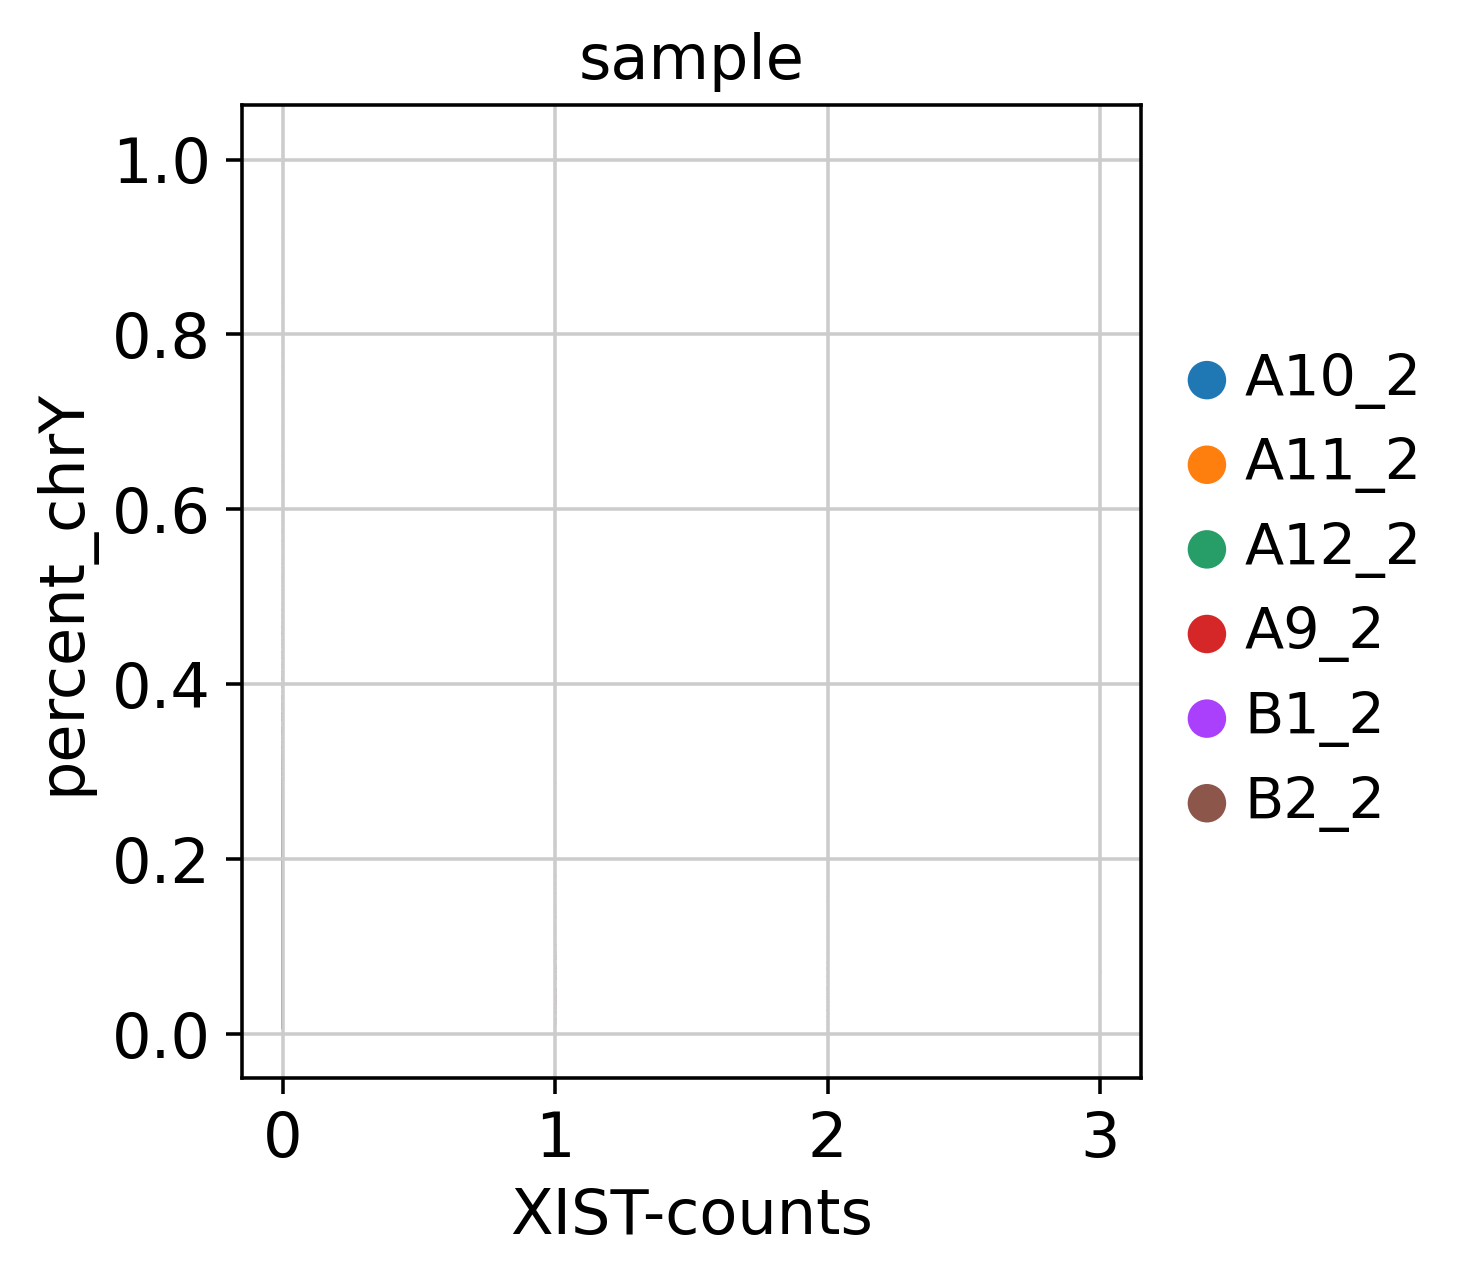

In [26]:
xist_counts = sample_object.X[:, sample_object.var_names.str.match('Xist')].toarray()
xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.obs_names, name = "XIST-counts")
sample_object.obs["XIST-counts"] = xist_counts_series

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "sample")

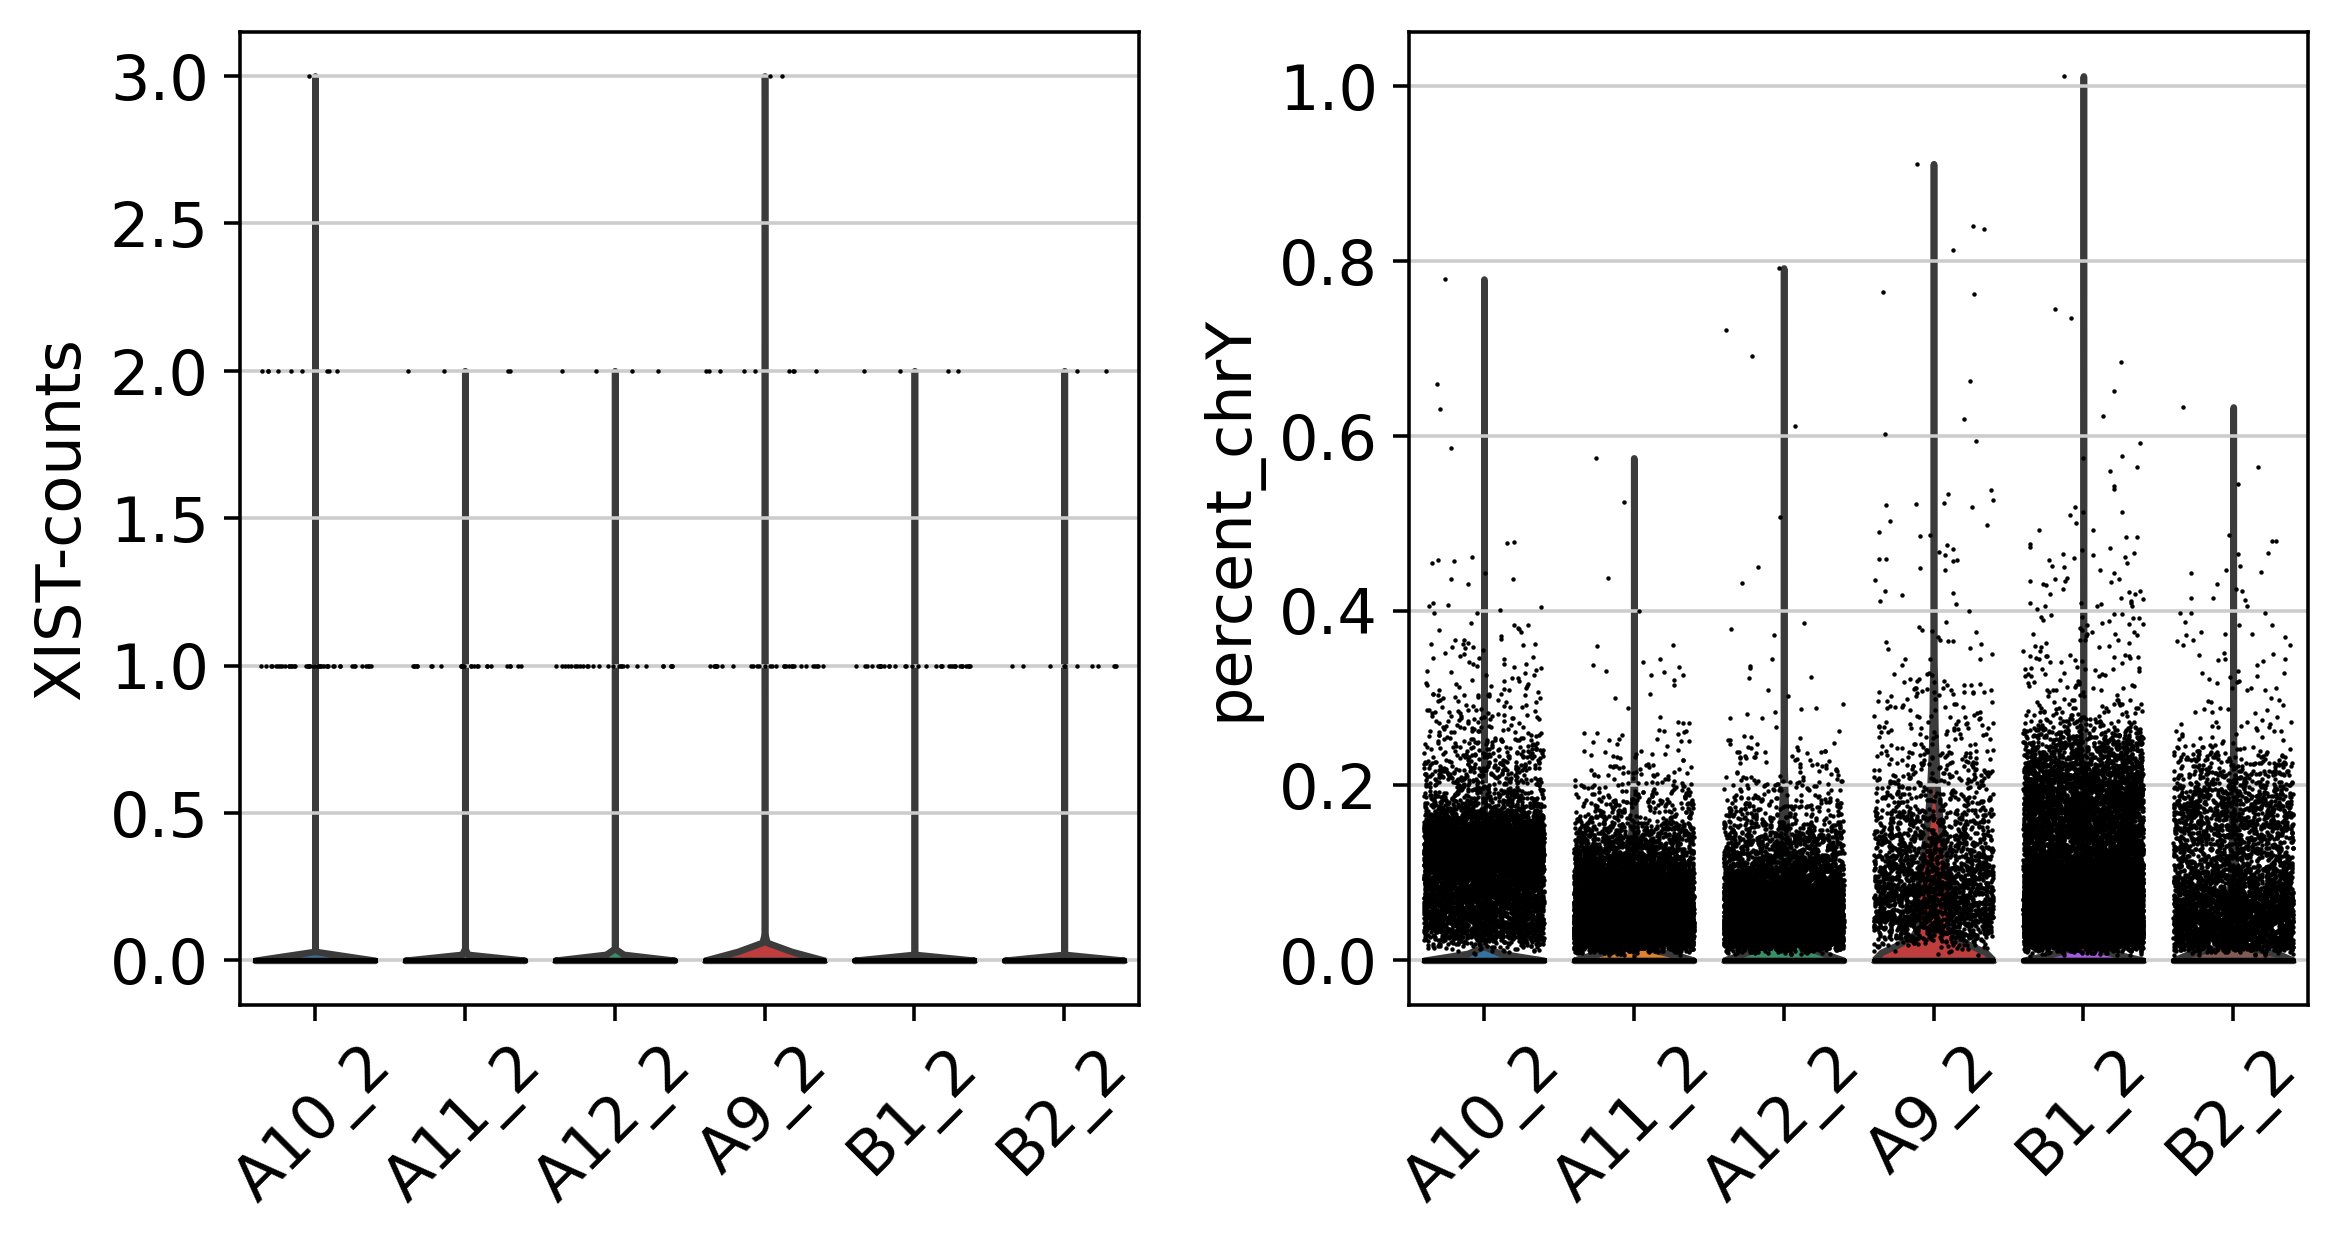

In [27]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'sample', rotation = 45)

### Calculate cell cycle scores

In [28]:
!if [ ! -f ../data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [29]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [30]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Fhl2', 'Col3a1', 'Plcl1', 'Igfbp5', 'Pid1', 'Tnnt2', 'Camk1d', 'Celf2', 'Gsn', 'Zeb2', 'Xirp2', 'Ttn', 'Fbn1', 'Plcb1', 'Plcb4', 'Tshz2', 'Fabp4', 'Lhfp', 'S100a9', 'Ank2', 'Ptprd', 'Nppa', 'Rbpj', 'Pcdh7', 'Myl2', 'Eln', 'Col1a2', 'Thsd7a', 'Chrm2', 'Cacna1c', 'Mgp', 'Nav2', 'Dlg2', 'Hbb-bt', 'Hbb-bs', 'Tacc2', 'Csmd1', 'Nrg1', 'Dlc1', 'Sorbs2', 'Palld', 'Cdh13', 'Tpm1', 'Rora', 'Slc9a9', 'Tmem108', 'Pde7b', 'Ctnna3', 'Dcn', 'Sptbn1', 'Hba-a1', 'Hba-a2', 'Ebf1', 'Col1a1', 'Meg3', 'Rian', 'Ighm', 'Ryr2', 'Cmah', 'F13a1', 'Mctp1', 'Pde8b', 'Mast4', 'Pde4d', 'Arl15', 'Ptprg', 'Myh6', 'Gpc6', 'Zbtb20', 'Cmss1', 'Col8a1', 'Airn', 'Gm26917', 'Gm42418', 'Rcan2', 'Slc8a1', 'Malat1', 'Prkg1', 'Sorbs1', 'Rbm20', 'Ablim1', 'Fgf13', 'Dmd', 'Tmsb4x', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    602 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


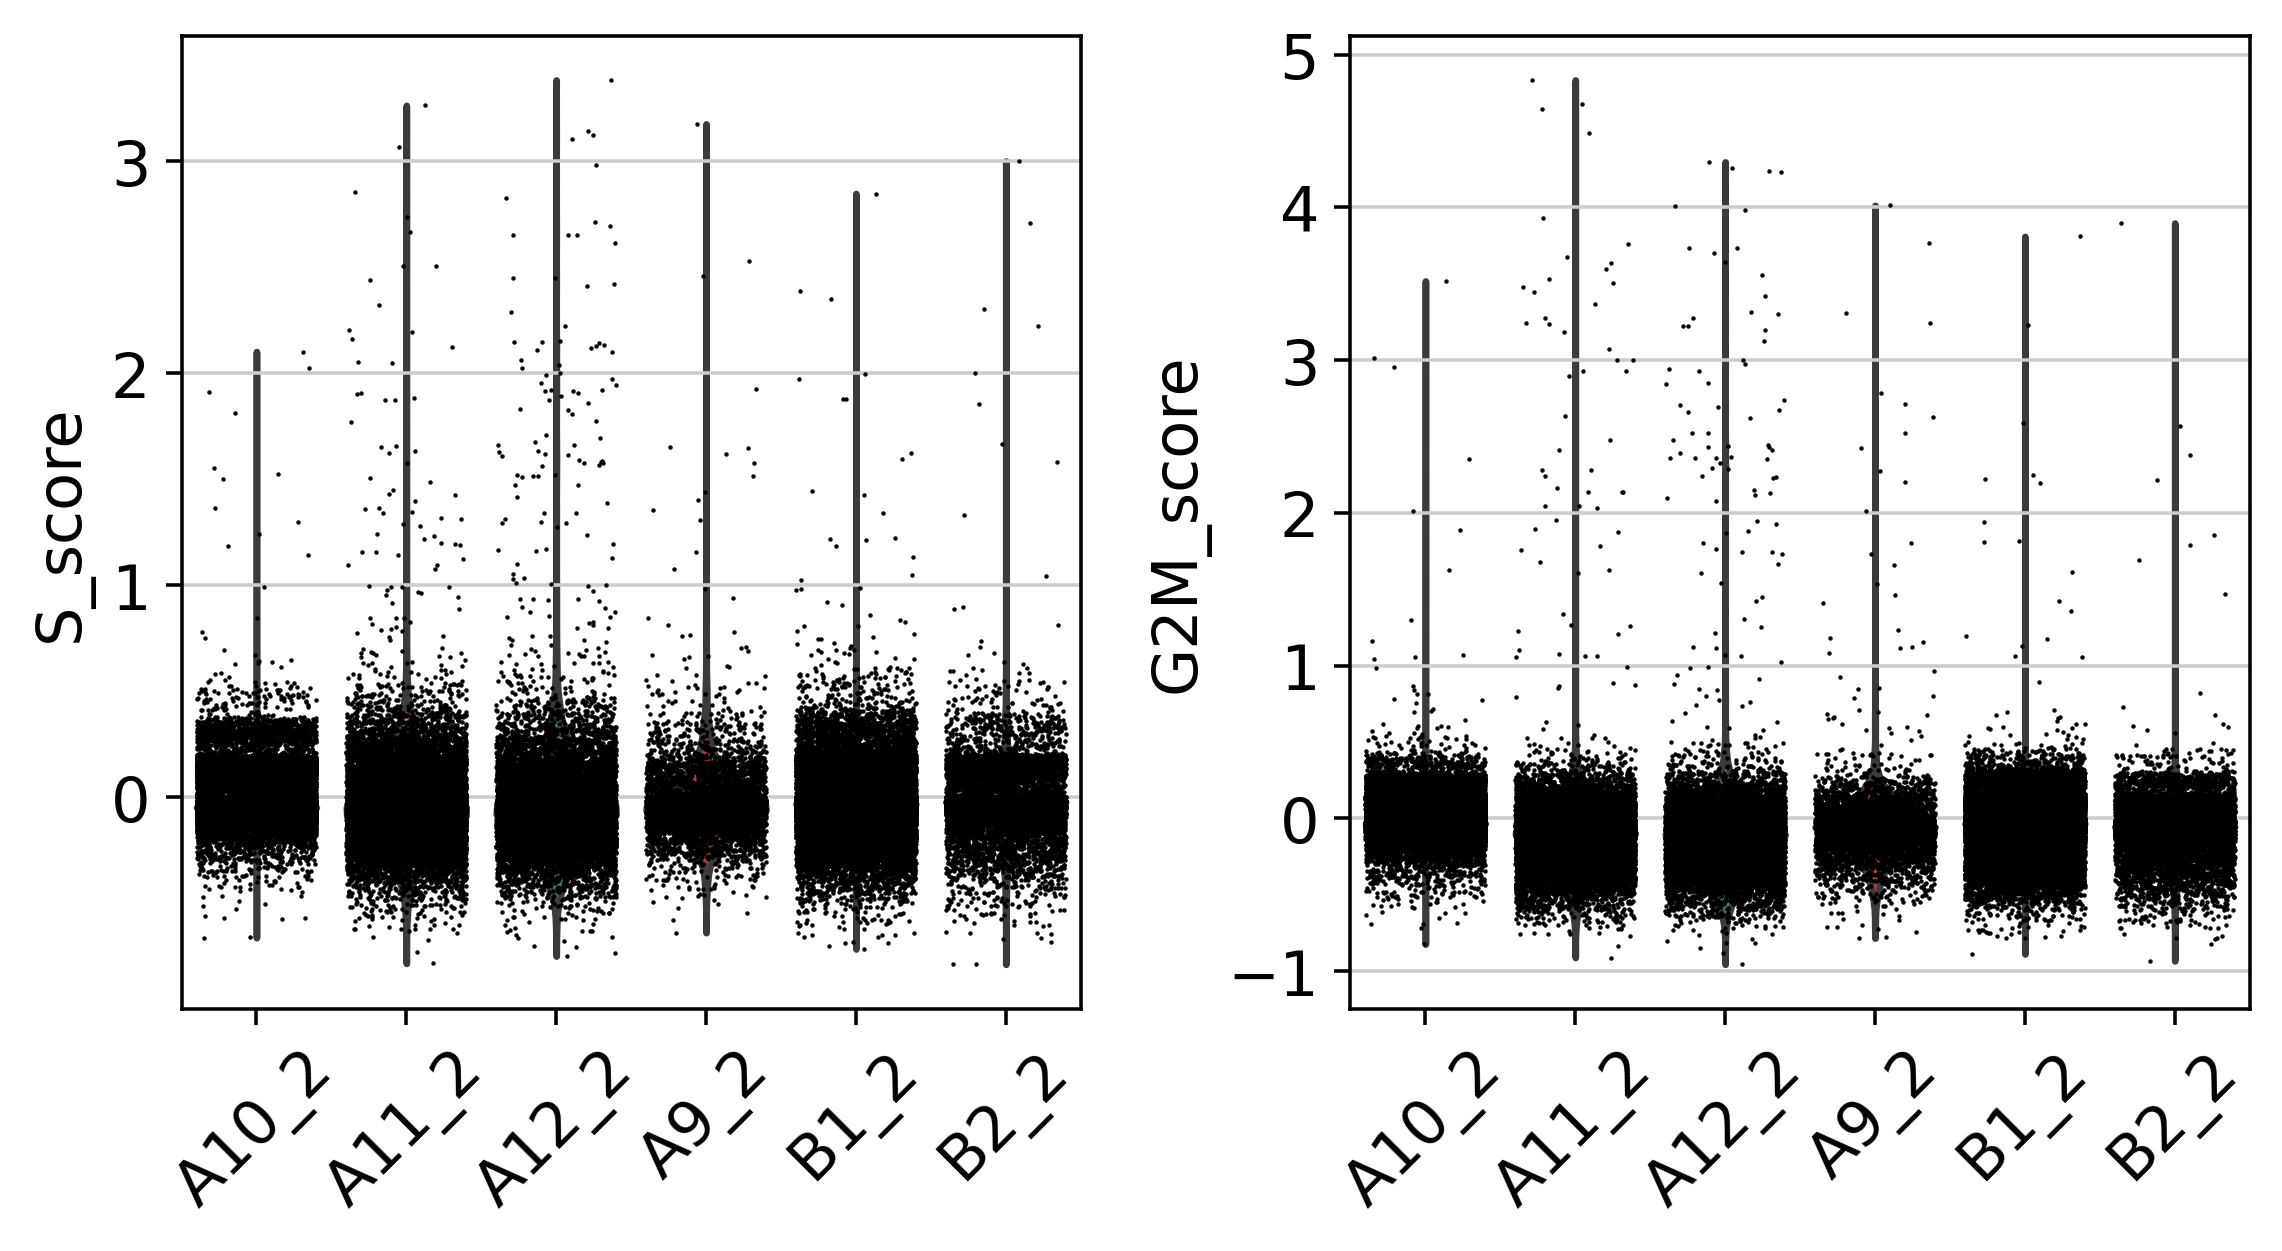

In [31]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'sample', rotation = 45)

In [32]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

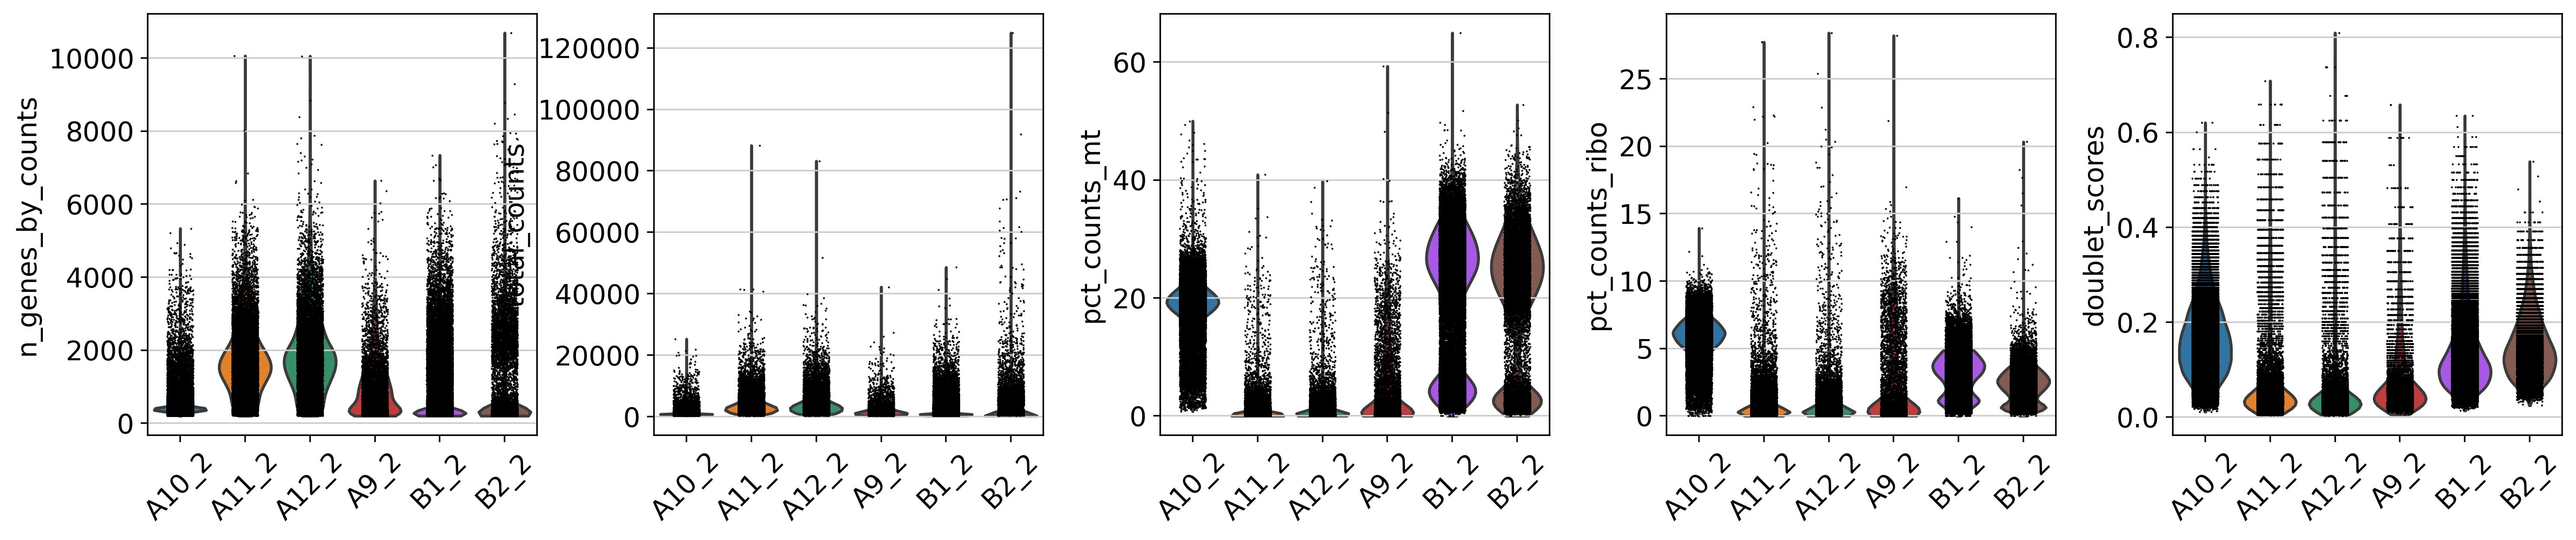

In [33]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'doublet_scores'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [34]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [35]:
del(sample_object.obs['predicted_doublets'])

### Export object

In [36]:
sample_object.write(path + 'heart_mm_nuclei-23-0092_CB_QCed_ctl230830.raw.h5ad')